In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import math
import os
import argparse
from functools import partial


def bce(q, p, eps=1e-9):
    return (q * (p + eps).log() + (1. - q) * (1. - p + eps).log()).neg()


def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

def clip_weight(discriminator, clip_value):
    for p in discriminator.parameters():
        p.data.clamp_(-clip_value, clip_value)


In [9]:
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Pad(padding=[2, 2, 2, 2])])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Pad(padding=[2, 2, 2, 2])])

train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=train_transform)
test_dataset  = datasets.MNIST(root='../data', train=False, download=True, transform=test_transform)

In [10]:

class Discriminator(nn.Module):
    def __init__(self, img_chs, chs):
        super().__init__()
        self.conv = [nn.Conv2d(img_chs, 1 * chs, 1, 1, 0), 
                     nn.LeakyReLU(0.2),
                     nn.Conv2d(1 * chs, 1 * chs, 4, 2, 1), 
                     nn.LeakyReLU(0.2),
                     nn.Conv2d(1 * chs, 2 * chs, 4, 2, 1), 
                     nn.LeakyReLU(0.2),
                     nn.Conv2d(2 * chs, 4 * chs, 4, 2, 1), 
                     nn.LeakyReLU(0.2),
                     nn.Conv2d(4 * chs, 8 * chs, 4, 2, 1), 
                     nn.LeakyReLU(0.2)]

        self.conv = nn.Sequential(*self.conv)
        
        self.output = [nn.Flatten(1, -1), 
                       nn.Linear(8 * chs * 2 * 2, 8 * chs), 
                       nn.LeakyReLU(0.2),
                       nn.Linear(8 * chs, 1)]
        self.output = nn.Sequential(*self.output)

    def forward(self, x):
        x = self.conv(x)
        x = self.output(x)
        return x


class Generator(nn.Module):
    def __init__(self, img_chs, chs, latent_size):
        super().__init__()
        self.latent_size = latent_size
        self.from_latent = [nn.Linear(latent_size, 8 * chs * 2), 
                            nn.ReLU(),
                            nn.Linear(8 * chs * 2, 8 * chs * 2 * 2), 
                            nn.ReLU(), 
                            nn.Unflatten(-1, (-1, 2, 2))]

        self.from_latent = nn.Sequential(*self.from_latent)

        self.conv = nn.Sequential(nn.ConvTranspose2d(8 * chs, 4 * chs, 4, 2, 1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(4 * chs),
                                  nn.ConvTranspose2d(4 * chs, 4 * chs, 4, 2, 1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(4 * chs),
                                  nn.ConvTranspose2d(4 * chs, 2 * chs, 4, 2, 1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(2 * chs),
                                  nn.ConvTranspose2d(2 * chs, 1 * chs, 4, 2, 1))
        self.output = nn.Sequential(nn.ReLU(), nn.Conv2d(chs, img_chs, 1, 1, 0))


    def forward(self, z):
        x = self.from_latent(z)
        x = self.conv(x)
        x = self.output(x)
        return x.tanh()

    def sample_latent(self, batch_size):
        device = next(self.parameters()).device
        return torch.randn(batch_size, self.latent_size).to(device)

    def sample(self, batch_size):
        z = self.sample_latent(batch_size)
        x = self(z)
        return x

In [11]:
args = argparse.Namespace()
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.img_chs = 1
args.img_rsl = 32

args.learning_rate = 2e-4
args.adam_betas = (0.0, 0.99)
args.batch_size = 128
args.chs = 64
args.gp_weight = 10.
args.hinge_loss = True

args.latent_size = 100


args.n_critic = 5

discriminator = Discriminator(args.img_chs, args.chs).to(args.device)
generator = Generator(args.img_chs, args.chs, args.latent_size).to(args.device)
d_optimizer = optim.Adam(discriminator.parameters(), lr=args.learning_rate, betas=args.adam_betas)
g_optimizer = optim.Adam(generator.parameters(),     lr=args.learning_rate, betas=args.adam_betas)

In [37]:
def partial_derivative(f, x):
    if not x.requires_grad:
        x.requires_grad = True

    fx = f(x)
    grad = torch.autograd.grad(outputs=fx, inputs=x, grad_outputs=torch.ones_like(fx),
                               create_graph=True)[0]
    return grad



In [39]:
loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
for epoch in range(100):
    stats = {'f_real': 0., 'f_fake': 0., 'g_norm': 0.}
    
    critic_iter = 0
    for x, y in loader:
        
        # train discriminator
        if critic_iter == 0:
            requires_grad(discriminator, True)
            requires_grad(generator, False)

        x = x.to(args.device)
        real_img = 2. * x - 1
        fake_img = generator.sample(args.batch_size)
        eps = torch.rand(args.batch_size, 1, 1, 1).to(args.device)
        x_hat = eps * real_img + (1 - eps) * fake_img


        d_optimizer.zero_grad()
        f_real = discriminator(real_img)
        f_fake = discriminator(fake_img)

        if args.hinge_loss:
            d_loss = F.relu(1 + f_fake).mean() + F.relu(1 - f_real).mean()

        else:
            d_loss = f_fake.mean() - f_real.mean()
        
        
        grad_hat = partial_derivative(discriminator, x_hat)
        grad_norm = grad_hat.square().sum(dim=[1, 2, 3]).sqrt()
        grad_penality = (grad_norm - 1).square().mean()
        d_loss = d_loss + args.gp_weight * grad_penality
        d_loss.backward()
        d_optimizer.step()

        critic_iter += 1

        # train generator
        if critic_iter % args.n_critic == 0:
            
            requires_grad(discriminator, False)
            requires_grad(generator, True)
            g_optimizer.zero_grad()
            g_fake_img = generator.sample(args.batch_size)
            g_f_fake = discriminator(g_fake_img)
            g_loss = - g_f_fake.mean()
            g_loss.backward()
            g_optimizer.step()

            critic_iter = 0

        stats['f_real'] += f_real.mean().item() / len(loader)
        stats['f_fake'] += f_fake.mean().item() / len(loader)
        stats['g_norm'] += grad_penality.mean().item() / len(loader)

    print(epoch, stats)

0 {'f_real': 1.7944934954468754, 'f_fake': -1.604482930257088, 'g_norm': 0.017678581140378208}
1 {'f_real': 1.6694730844619299, 'f_fake': -1.5908019903442292, 'g_norm': 0.017217262958486888}
2 {'f_real': 1.6660256673120206, 'f_fake': -1.460981106234349, 'g_norm': 0.022666564056028935}
3 {'f_real': 1.5348365327709506, 'f_fake': -1.306357436614413, 'g_norm': 0.021075525966823175}
4 {'f_real': 1.5783203303750242, 'f_fake': -1.2351643540299468, 'g_norm': 0.01670742859271888}
5 {'f_real': 1.445309076808456, 'f_fake': -1.1529476230995903, 'g_norm': 0.01334966219460163}
6 {'f_real': 1.3044869533907135, 'f_fake': -1.0925546728918332, 'g_norm': 0.01192212354443553}
7 {'f_real': 1.3246215820694591, 'f_fake': -1.1063153627527584, 'g_norm': 0.01046115364162967}
8 {'f_real': 1.259054188051413, 'f_fake': -1.0637160887480026, 'g_norm': 0.012535352698670562}
9 {'f_real': 1.1631039873911775, 'f_fake': -1.0334722757435009, 'g_norm': 0.010963002639687339}
10 {'f_real': 1.076607010558121, 'f_fake': -1.003

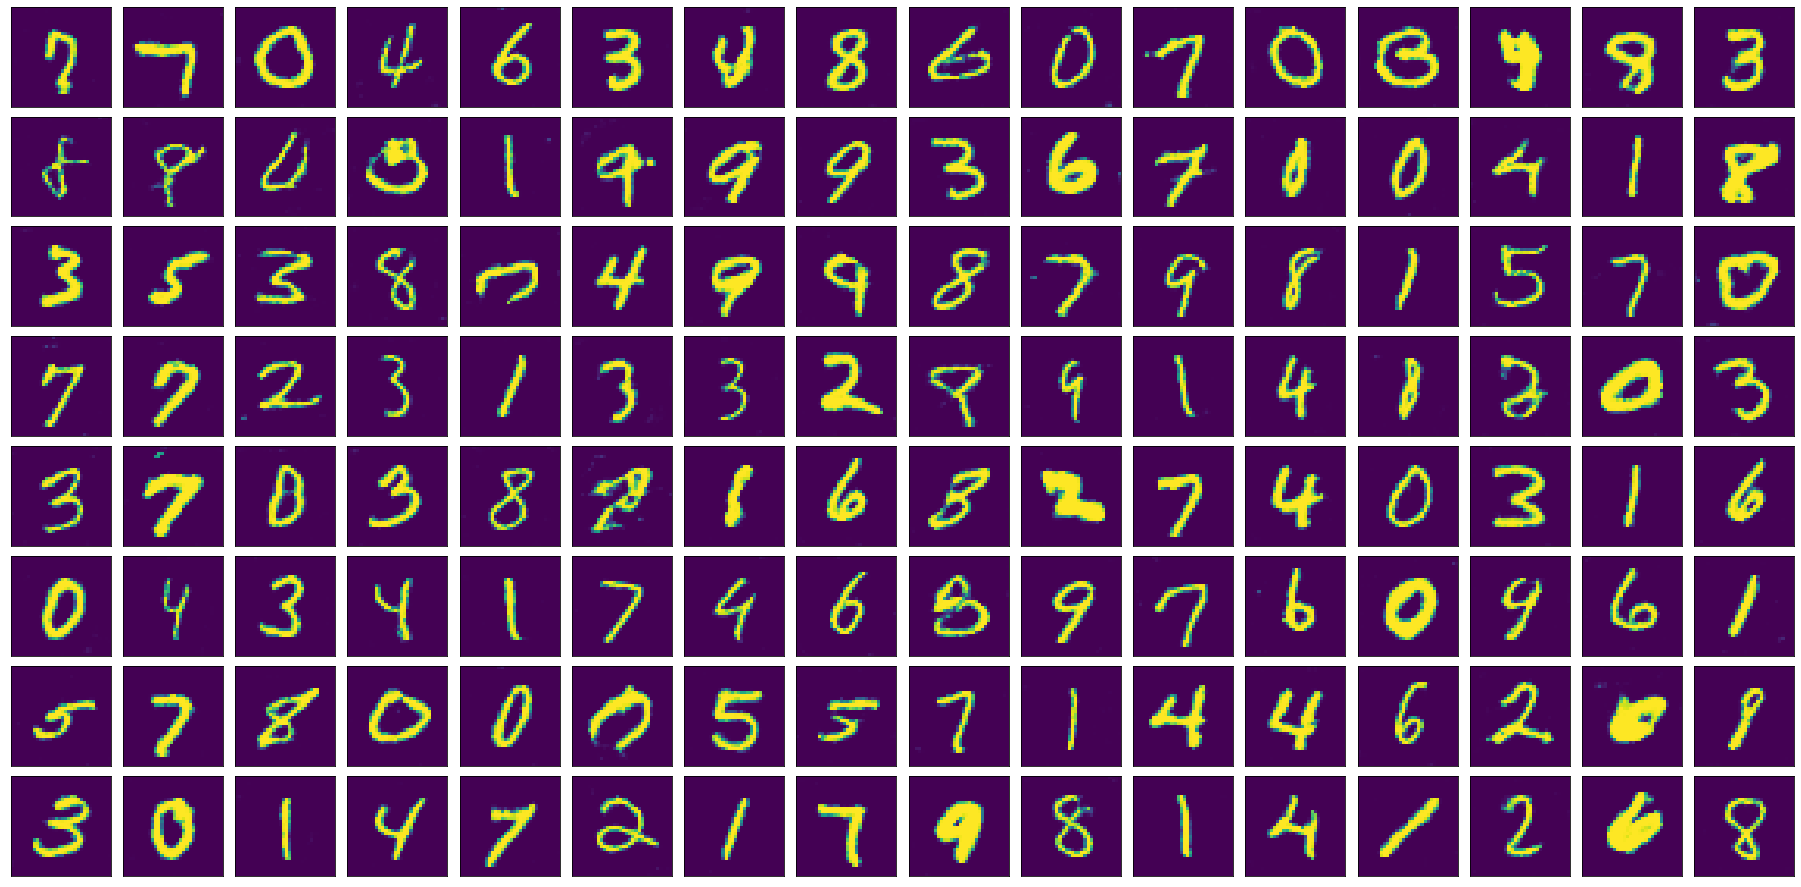

In [40]:
@torch.no_grad()
def generate(model, batch_size):
    fake = model(torch.randn(128, args.latent_size).to(args.device))
    fake = 0.5 * (fake + 1)
    fake = fake.clamp(0., 1.)
    fake = fake.permute(0, 2, 3, 1)
    if fake.size()[-1] == 1:
        fake = fake.squeeze(dim=-1)
    fake = fake.detach().cpu().numpy()
    return fake


gen = generate(generator, 128)


fig = plt.figure(figsize=(16 * 2, 8 * 2))
for i in range(8 * 16):
    sub_fig = fig.add_subplot(8, 16, i + 1, xticks=[], yticks=[])
    sub_fig.imshow(gen[i])
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()